In [1]:
import torch
import torch.nn as nn
import gym
from itertools import count
import numpy as np
import random
import torch.nn.functional as F
import itertools

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[0]).unwrapped

discrete_actions = True
#TODO
#parralel fitness measuring
from helper import *
%matplotlib inline
import matplotlib.pyplot as plt
import random

#seed = 69
#random.seed(seed)
#np.random.seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.manual_seed(seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Creature(nn.Module):
    def __init__(self):
        super(Creature, self).__init__()
    
        self.layer1 = nn.Linear(env.observation_space.shape[0], 6)
        self.layer2 = nn.Linear(6, 6)
        
        if discrete_actions:
            self.layer3 = nn.Linear(6, env.action_space.n)
        else:
            self.layer3 = nn.Linear(6, env.action_space.shape[0])
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
input_num = (len(get_params(Creature()))*2)+1 
output_num = len(get_params(Creature()))
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose1d(input_num, 128, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(True))
        
        
        self.layer5 = nn.Linear(16*13, output_num)
        
    def forward(self, mom,dad,a):
        #print(a)
        out = torch.cat([mom,dad,a]).unsqueeze(0)
        out = out.unsqueeze(-1)
        #print(out.shape)
        out = self.layer1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        out = self.layer5(out)
        z = torch.zeros(mom.shape).to(device)
        mom_func = (mom+(torch.tanh(out+3)*a)) * (torch.min(mom,z)/mom+0.0001)
        dad_func = (dad+(torch.tanh(-out+3)*a)) * (torch.max(dad,z)/(dad+0.0001))
        out = mom_func + dad_func
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 8, 5, stride=1, padding=0),  
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer4 = nn.Linear(16*59, 128)
        self.layer5 = nn.Sequential(       
            nn.Linear(128, 1))#,
            #nn.Sigmoid())
    def forward(self, out):
        
        out = out.unsqueeze(1)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #print(out.shape)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        
        out = self.layer4(out)
        out = self.layer5(out)
        #out = torch.pow(out,3)*10
        
        return out
    
a = np.array([random.randint(0,1000)/10000])
a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")
gen = Generator().to(device)
gen(torch.zeros([(len(get_params(Creature())))]).to(device),
   torch.zeros([(len(get_params(Creature())))]).to(device),
   a).shape

dis = Discriminator().to(device)
dis(torch.zeros([10,len(get_params(Creature()))]).to(device)).shape    

torch.Size([10, 1])

In [3]:
def mate(m,d,mutation_rate_m,mutation_rate_d,child_mutation_rate,use_gen,mutation_scale=0.07):
    child = Creature()
    mom = (m)
    dad = (d)
    mutation_rate = np.min([mutation_rate_m,mutation_rate_d])
    mom = mutate(mom,mutation_rate_m,mutation_scale)
    dad = mutate(dad,mutation_rate_d,mutation_scale)
    mom = get_params(mom)
    dad = get_params(dad)
    if random.randint(0,100) < 0:
        a = np.array([random.uniform(0.2,0.5)])
        a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")

    else:
        a = np.array([0.01])
        a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")
    generated = use_gen(mom,dad,a).squeeze(0)
    child = set_params(child,generated)

    child = mutate(child,child_mutation_rate,mutation_scale)
    #child = mutate(child,np.mean([mutation_rate_m,mutation_rate_d]),mutation_scale)
    
    return child

def mutate(creature,mutation_rate=0.2,scale = 0.07,start_layer = 0):
    if mutation_rate != 0:
        new = creature.__class__().to(device)
        new.load_state_dict(creature.state_dict()) 
        for idx,p in enumerate(new.parameters()):
            if idx < start_layer:
                continue
            mutation = np.random.normal(scale = scale,size = p.data.shape)
            mutation *= np.random.choice([1, 0], p.data.shape,p=[mutation_rate,1-mutation_rate])
            mutation = torch.from_numpy(mutation).type('torch.FloatTensor').to(device)
            p.data += mutation
        return new
    else:
        return creature

def evolve(population,out_size,new_gen,old_gen,p_fitness,child_mutation_rate,mutation_rate,mutation_scale):
    pick_probabilities = get_pick_probabilities(p_fitness)
    choice = np.random.choice(pick_probabilities.size,out_size+1, p = pick_probabilities)
    new_population = []
    parent_fitness = []
    for p in range(out_size):
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        par_fit = np.max([p_fitness[choice[p]],p_fitness[choice[p+1]]])
        
        use_gen = new_gen
        
        child = mate(first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],child_mutation_rate,use_gen,mutation_scale).to(device)
        
        parent_fitness.append(par_fit)
        new_population.append(child)
        
    #child = mate(population[0],population[len(population)-1] 
    #             ,mutation_rate[0],mutation_rate[len(population)-1],child_mutation_rate,use_gen,mutation_scale).to(device) 
    parent_fitness.append(np.max([p_fitness[0],p_fitness[len(p_fitness)-1]]))
    
    new_population.append(child)
    
    return new_population, np.array(parent_fitness)



In [4]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    
    #var = (np.max(p_fitness)-np.min(p_fitness))
    #var = np.median(p_fitness-np.min(p_fitness))
    var = np.log(np.var(p_fitness))+5
    print(var)
    p_fitness = torch.from_numpy(p_fitness).to(device).type("torch.cuda.FloatTensor")
    gen_error = 1000
    dis_error_fake = 1000
    dis_error_real = 1000
    e = 0
    
    gen_loss_all = []
    dis_loss_all = []
    rec_loss_all = []
    for e in range(n_epochs):
        
        #shuffle arrays in unison
        #ind = np.arange(len(population))
        #np.random.shuffle(ind)
        #population = np.array(population)[ind]
        #p_fitness = p_fitness[ind]
        
        for i in range(len(population)//batch_size):

            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            if e % 1 == 0:
                #train discriminator on population
                if dis_error_real > 0.05:

                    dis_out_r = dis(real_batch).squeeze(-1)
                    #stack = [ranking[i*batch_size:(i*batch_size)+batch_size],torch.ones(batch_size).to(device)]
                    #stack = torch.stack(stack)

                    #dis_error_real = nn.BCELoss()(dis_out,
                        #ranking[i*batch_size:(i*batch_size)+batch_size])#torch.ones(batch_size).to(device))
                    #dis_error_real = nn.BCELoss()(dis_out,stack.transpose(0,1))
                    
                    rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
                    #dis_error_real = torch.log(nn.L1Loss()(dis_out_r,rank)+1)
                    #var = ((np.max(p_fitness)-np.min(p_fitness)))
                    
                    #dis_error_real = F.softplus((nn.L1Loss()(dis_out_r,rank))-10)#-(var))#/var
                    #dis_error_real = (nn.MSELoss()(dis_out_r,rank))
                    dis_error_real = (nn.MSELoss()(dis_out_r,rank))
                    if e == n_epochs-1:
                        print(dis_out_r)
                    dis_error_real.backward()
                
        
            mom = []
            dad = []
            child = []
            #a = np.array([random.uniform(0.2,0.5)])
            a = np.array([0.01])
            a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")
            for b in range(batch_size):
                m = get_params(random.choice(population))
                d = get_params(random.choice(population))
                #c_data = torch.cat([m,d]).unsqueeze(0)
                #a = torch.from_numpy(np.random.rand(d.numel()) * 0.1).to(device).type("torch.cuda.FloatTensor")
                #a = np.array([random.randint(0,1000)/10000]*batch_size)

                #a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor").unsqueeze(-1)
                c = gen(m,d,a).squeeze(0)

                mom.append(m)
                dad.append(d)
                child.append(c)

            mom = torch.stack(mom).to(device)
            dad = torch.stack(dad).to(device)
            child = torch.stack(child).to(device)
            dis_out_f = dis(child).squeeze(-1)
            
            if e % 1== 0: #and torch.mean(dis_out_f)>torch.min(p_fitness):
                #train discriminator on generator output
                
                #dis_error_fake = nn.MSELoss()(dis_out_f,torch.zeros(dis_out_f.shape).to(device))
                #dis_error_fake = F.softplus((nn.L1Loss()(dis_out_f,torch.zeros(dis_out_f.shape).to(device)))-10)
                dis_error_fake = torch.mean(dis_out_f)
                #if gen_error < 0.5:#dis_error_fake > 0.3:
                dis_error_fake.backward(retain_graph=True)

            dis_optimizer.step() 
            
            #train generator
            
            #gen_error = nn.BCELoss()(dis_out_f,torch.ones(dis_out_f.shape).to(device))
            #gen_error = -nn.MSELoss()(dis_out_f,torch.zeros(dis_out_f.shape).to(device))
            gen_error = -torch.mean(dis_out_f)
            total_gen_error = gen_error # + child_error
            if e % 1 == 0:
                total_gen_error.backward()
                gen_optimizer.step()
            
        gen_loss_all.append(gen_error)
        dis_loss_all.append(dis_error_fake)#+dis_error_real)
        rec_loss_all.append(dis_error_real)    
            
        #if e %  5 == 0:    
        #print("Discriminator loss real : {}".format(dis_error_real))
        #print("Discriminator loss generated : {}".format(dis_error_fake))
        #print("Generator loss : {}".format(gen_error))
        #print("Child error : {}".format(child_error*0.1))
        #print("")
    return gen_loss_all, dis_loss_all, rec_loss_all

starting training
86
population fitness : [23. 10.]
min fit : nan
population fitness : [1.99999998 0.        ]
4.999999976331361


/home/liam/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/liam/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater


tensor([ 1.6950, -0.3936], device='cuda:0', grad_fn=<SqueezeBackward1>)


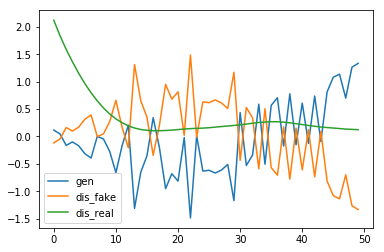

Generation 1  fitness : 1.9999999763313616
#################################
population fitness : [ 19.  10.  11. 100. 113.]
min fit : 113.0
population fitness : [0.41364601 0.21770843 0.23947927 2.17708427 2.46010522]
4.999999999526031
tensor([-0.0630,  0.0045, -0.1133,  1.4991],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


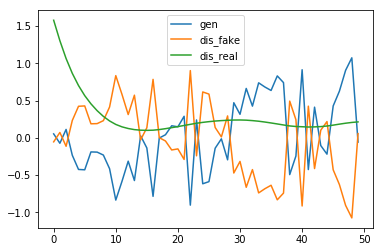

Generation 2  fitness : 2.460105219957085
#################################
population fitness : [ 9. 10.  8. 19.  8.  9. 10.]
min fit : 19.0
population fitness : [2.45316101 2.73249141 2.17383061 5.24646499 2.17383061 2.45316101
 2.73249141]
4.999999921974526
tensor([2.2179, 2.1615, 1.6459, 4.3333, 2.2131, 1.8732],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


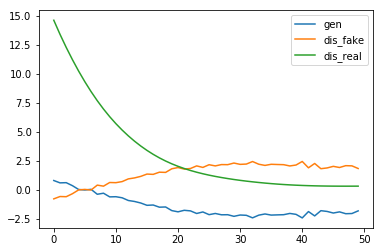

Generation 3  fitness : 5.246464993078482
#################################
population fitness : [17.  9.  8. 17. 10. 20.  9. 66. 66.]
min fit : 66.0
population fitness : [0.66011908 0.30392777 0.25940386 0.66011908 0.34845169 0.79369082
 0.30392777 2.84179083 2.84179083]
4.99999999801762
tensor([ 0.1315, -0.2096, -0.2262,  0.2156, -0.1140,  0.3780, -0.1676,  2.1758],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


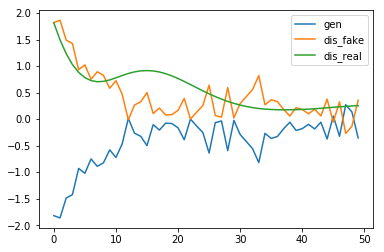

Generation 4  fitness : 2.8417908288152143
#################################
population fitness : [ 10.  10.  10.   9.  13.   8. 364.  14.  13.]
min fit : 189.0
population fitness : [0.0877587  0.0877587  0.0877587  0.07874912 0.11478745 0.06973954
 3.27715083 0.12379703 0.11478745]
4.999999999918827
tensor([-0.4503, -0.4034, -0.2511, -0.2898, -0.2239, -0.2695,  2.9892, -0.7795],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


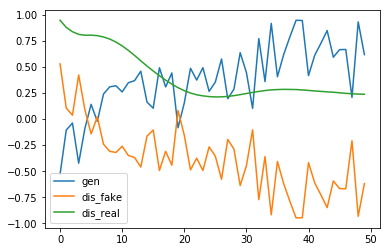

Generation 5  fitness : 3.277150829964446
#################################
population fitness : [ 10.  10.  10.   9.  11. 343.  16.  20.  14.]
min fit : 181.5
population fitness : [0.09555518 0.09555518 0.09555518 0.08593255 0.1051778  3.29988946
 0.15329093 0.19178143 0.13404568]
4.999999999907405
tensor([-0.4049, -0.3061, -0.3133, -0.3665, -0.2892,  3.0820, -0.4253, -0.6333],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


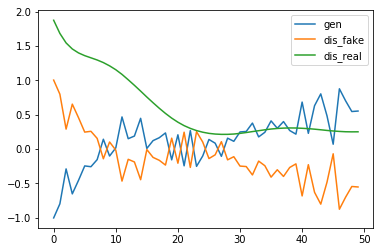

Generation 6  fitness : 3.299889463768852
#################################
population fitness : [25. 53. 32. 10. 32. 10. 18. 16. 19.]
min fit : 42.5
population fitness : [1.93832515 4.11673718 2.48292816 0.77131871 2.48292816 0.77131871
 1.39372214 1.23812128 1.47152257]
4.999999993947093
tensor([1.4826, 3.5488, 1.8983, 0.3642, 2.1549, 0.3127, 0.8946, 0.4638],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


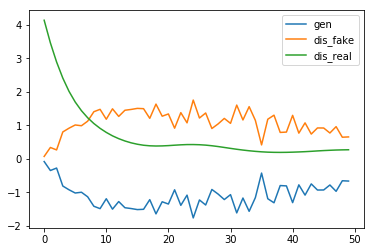

Generation 7  fitness : 4.1167371818171565
#################################
population fitness : [  9.  19.  10.  10.   9.  74. 205.  29.  50.]
min fit : 139.5
population fitness : [0.13708359 0.303676   0.15374283 0.15374283 0.13708359 1.21993428
 3.40229489 0.47026841 0.82011248]
4.99999999972247
tensor([-0.3081, -0.2114, -0.3640, -0.3336, -0.3524,  0.8701,  3.1632, -0.2534],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


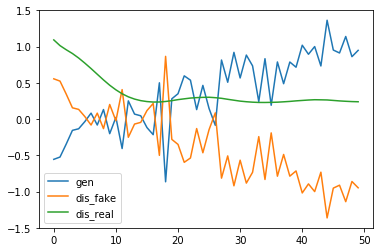

Generation 8  fitness : 3.4022948942315097
#################################
population fitness : [12. 13. 10. 10. 19. 17. 11. 14. 12.]
min fit : 18.0
population fitness : [4.05864351 4.40077216 3.37438622 3.37438622 6.45354402 5.76928674
 3.71651487 4.7429008  4.05864351]
4.999999882947983
tensor([3.7228, 4.0204, 2.5618, 3.3721, 5.1907, 4.7658, 3.1875, 3.8388],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


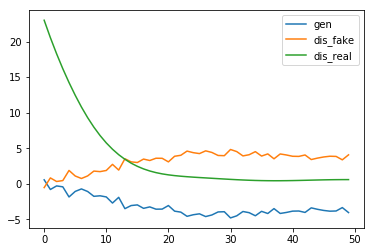

Generation 9  fitness : 6.453544024350422
#################################
population fitness : [ 28. 139.  10.  21.   9.  25.  10.  51.  48.]
min fit : 95.0
population fitness : [0.63732207 3.51005247 0.17147389 0.45615889 0.14559344 0.5596807
 0.17147389 1.23257251 1.15493115]
4.999999999330202
tensor([ 0.4274,  2.7011, -0.0611,  0.1078, -0.1057,  0.0379, -0.1947,  1.0765],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


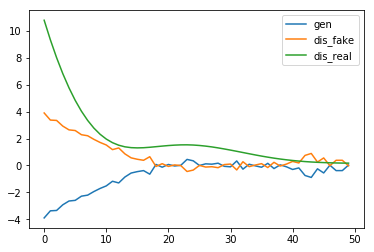

Generation 10  fitness : 3.51005246710586
#################################
population fitness : [ 50.   9. 120.  15.  15.  85.  11.  12.  15.]
min fit : 102.5
population fitness : [1.31688744 0.23388618 3.16591397 0.39237417 0.39237417 2.24140071
 0.28671551 0.31313018 0.39237417]
4.999999999302266
tensor([ 0.8205, -0.2928,  2.6777, -0.0165, -0.0819,  1.8405, -0.0725, -0.4346],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


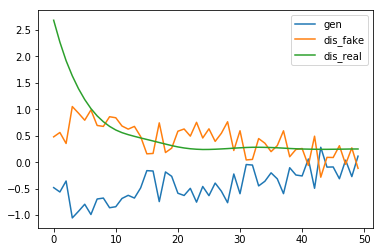

Generation 11  fitness : 3.165913972617273
#################################
population fitness : [18.  9. 10. 11. 53. 13. 12. 20. 20.]
min fit : 36.5
population fitness : [1.38252126 0.68216037 0.75997824 0.83779612 4.10614695 0.99343187
 0.915614   1.53815701 1.53815701]
4.999999993944378
tensor([0.8814, 0.3139, 0.1877, 0.2319, 3.7285, 0.6374, 0.5476, 0.7231],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


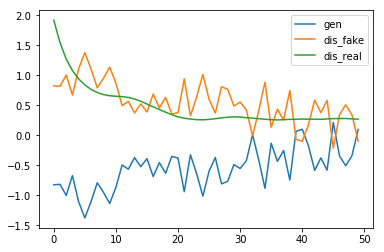

Generation 12  fitness : 4.106146952244704
#################################
population fitness : [ 62. 129. 119.   9.  42. 636.  10.   9.   9.]
min fit : 382.5
population fitness : [0.3229179  0.67575975 0.62309679 0.04380421 0.21759198 3.3457719
 0.0490705  0.04380421 0.04380421]
4.999999999972267
tensor([-0.0577,  0.3638,  0.1149, -0.5343, -0.1555,  2.9474, -0.4071, -0.7551],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


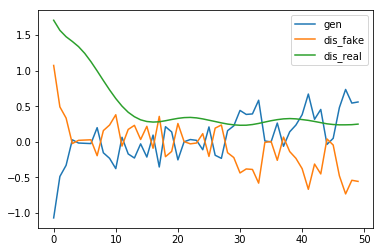

Generation 13  fitness : 3.3457719036963005
#################################
population fitness : [ 40.  27.  34.  21.  10. 400. 111. 147. 104.]
min fit : 273.5
population fitness : [0.34607695 0.23347864 0.2941085  0.18151018 0.08623468 3.46418418
 0.96103699 1.27284771 0.90040713]
4.99999999992498
tensor([-0.1174, -0.1099,  0.0161, -0.2589, -0.3375,  2.9278,  0.4968,  0.2915],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


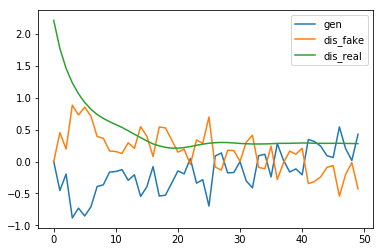

Generation 14  fitness : 3.464184181468509
#################################
population fitness : [5000.   53.   15.   36.   10.   34.   44.   19.   22.]
min fit : 2526.5
population fitness : [3.20045378 0.0338702  0.00954633 0.02298847 0.00634582 0.02170826
 0.02810928 0.01210674 0.01402704]
4.9999999999995905
tensor([ 2.7479, -0.4296, -0.3702, -0.5147, -0.3778, -0.5943, -0.3280, -0.9827],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


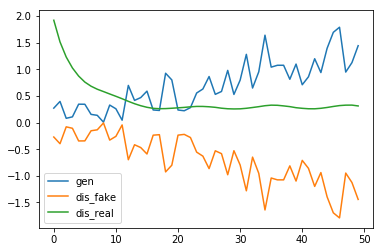

Generation 15  fitness : 3.2004537750835564
#################################
population fitness : [  64.  300.   44.  186.   10.  119.  336. 1176.  706.]
min fit : 941.0
population fitness : [0.17687199 0.82915212 0.12159401 0.51406765 0.02762145 0.32888643
 0.92865248 3.25032753 1.95129506]
4.999999999992361
tensor([-0.2609,  0.4771, -0.3022,  0.1247, -0.4147, -0.2115,  0.5250,  2.4157],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


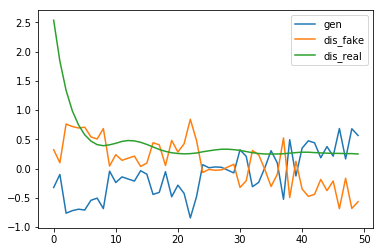

Generation 16  fitness : 3.25032753485689
#################################
population fitness : [  10.   10. 5000.  160.  323. 5000.  238.  195.  192.]
min fit : 5000.0
population fitness : [0.00495175 0.00495175 2.48271865 0.07943372 0.1603708  2.48271865
 0.11816435 0.09681285 0.09532321]
4.999999999999753
tensor([-0.3736, -0.3986,  1.9161, -0.1861, -0.5057,  2.0595, -0.3944, -0.5669],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


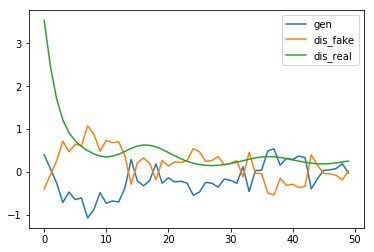

Generation 17  fitness : 2.482718647219969
#################################
population fitness : [ 668.   58.  100.  159.  227.   10. 5000.    8.    9.]
min fit : 2834.0
population fitness : [0.43511843 0.0377768  0.06513475 0.10356615 0.14785997 0.00651057
 3.25689541 0.00520781 0.00585919]
4.9999999999995755
tensor([ 0.0351, -0.2642, -0.3896, -0.1761, -0.3247, -0.4170,  2.8448, -0.8390],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


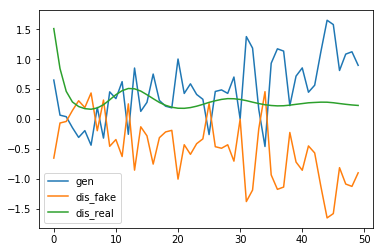

Generation 18  fitness : 3.2568954091530795
#################################
population fitness : [5000.  492. 5000.  138.  203.    9.  654. 5000. 5000.]
min fit : 5000.0
population fitness : [2.13441858 0.21002478 2.13441858 0.05890779 0.08665526 0.00383973
 0.27918002 2.13441858 2.13441858]
4.999999999999817
tensor([ 1.6462, -0.2026,  1.7040, -0.1848, -0.1725, -0.4080, -0.3014,  1.1724],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


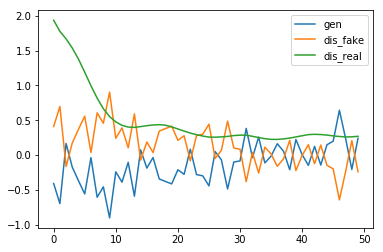

Generation 19  fitness : 2.1344185839176126
#################################
population fitness : [  14. 5000.   14.   99.   29. 5000. 5000.  568.  347.]
min fit : 5000.0
population fitness : [0.00614057 2.19366032 0.00614057 0.04343282 0.01272156 2.19366032
 2.19366032 0.24919832 0.15223846]
4.999999999999807
tensor([-0.2912,  1.7584, -0.3092, -0.4777, -0.5146,  1.7171,  1.6758, -0.6408],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


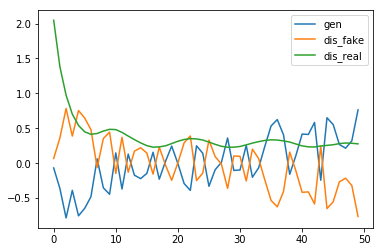

Generation 20  fitness : 2.1936603242206614
#################################
population fitness : [5000. 5000. 5000.   10.   12. 5000.  100.    9.    9.]
min fit : 5000.0
population fitness : [2.02367248 2.02367248 2.02367248 0.00404486 0.00485433 2.02367248
 0.04047101 0.00364013 0.00364013]
4.999999999999837
tensor([ 1.4833,  1.5043,  1.7180, -0.3619, -0.4746,  1.5004, -0.6159, -0.9239],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


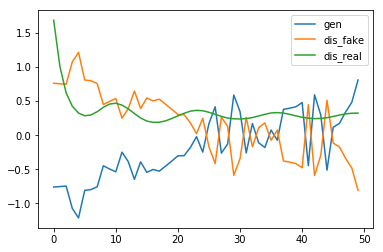

Generation 21  fitness : 2.023672482516505
#################################
population fitness : [5000.  109.   12.  170. 5000.   10. 5000. 5000. 5000.]
min fit : 5000.0
population fitness : [2.04286182 0.04453293 0.00490138 0.06945587 2.04286182 0.00408424
 2.04286182 2.04286182 2.04286182]
4.999999999999833
tensor([ 1.7682, -0.5087, -0.4830, -0.4808,  1.5788, -0.4300,  1.5601,  1.2646],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


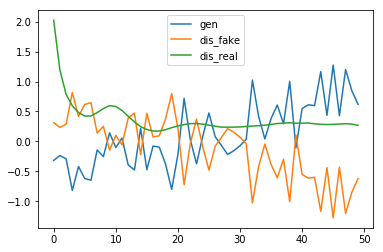

Generation 22  fitness : 2.042861818459953
#################################
population fitness : [5000.   10.   10. 5000.   22. 5000. 5000.  235.  250.]
min fit : 5000.0
population fitness : [2.05458305 0.00410749 0.00410749 2.05458305 0.00903849 2.05458305
 2.05458305 0.0965638  0.10272756]
4.999999999999831
tensor([ 1.3484, -0.6005, -0.2329,  1.8409, -0.4664,  1.4888,  1.6659, -0.5549],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


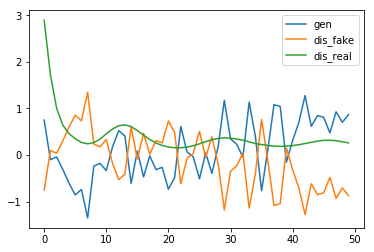

Generation 23  fitness : 2.054583046379925
#################################
population fitness : [5000. 5000.   10.    9. 5000.  156. 5000. 5000. 5000.]
min fit : 5000.0
population fitness : [2.14604512 2.14604512 0.00429033 0.00386112 2.14604512 0.0669549
 2.14604512 2.14604512 2.14604512]
4.999999999999816
tensor([ 1.8008,  1.6238, -0.4448, -0.5029,  1.7947, -0.3358,  1.7663,  1.5021],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


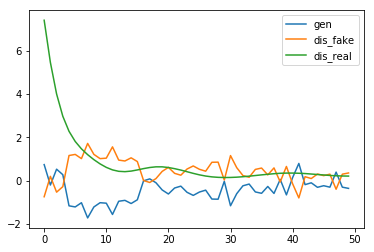

Generation 24  fitness : 2.1460451215150647
#################################
population fitness : [   9.  470. 3914. 5000.  362.   11.  161.  129.  198.]
min fit : 4457.0
population fitness : [0.00500554 0.26151022 2.17778383 2.78204433 0.20141802 0.00611835
 0.08957975 0.07177465 0.11016689]
4.99999999999969
tensor([-0.6294, -0.2973,  1.8177,  2.2786, -0.3457, -0.4116, -0.3689, -0.5001],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


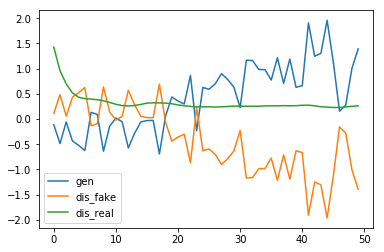

Generation 25  fitness : 2.7820443272724766
#################################
population fitness : [  47.  301. 5000. 5000.  579. 5000. 5000. 5000. 5000.]
min fit : 5000.0
population fitness : [0.02121753 0.1358947  2.2574224  2.2574224  0.26140752 2.2574224
 2.2574224  2.2574224  2.2574224 ]
4.999999999999796
tensor([-0.5096, -0.3171,  1.8101,  1.6998, -0.0309,  1.7223,  1.7588,  1.4991],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


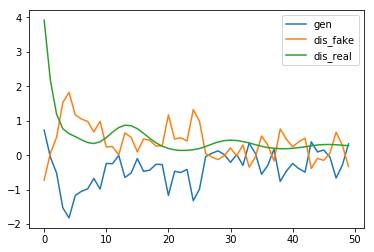

Generation 26  fitness : 2.2574224013173345
#################################
population fitness : [ 114.  378. 1004.  592.  896.  348.  228.  790. 1376.]
min fit : 1190.0
population fitness : [0.29269928 0.97065537 2.57823306 1.52021068 2.30088739 0.8936149
 0.58545304 2.02867775 3.53353482]
4.999999999993405
tensor([-0.1588,  0.4013,  2.0193,  0.9586,  1.9121,  0.4109,  0.1013,  1.2665],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


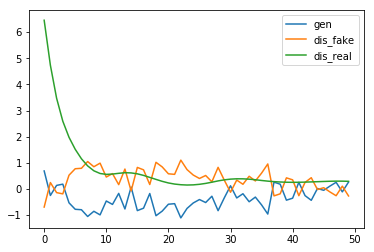

Generation 27  fitness : 3.5335348187171123
#################################
population fitness : [5000.   47.  299.  345. 5000.   12. 5000.   64.   61.]
min fit : 5000.0
population fitness : [2.17899993 0.02035623 0.13018426 0.15023223 2.17899993 0.00510234
 2.17899993 0.02776527 0.02645779]
4.99999999999981
tensor([ 1.5283, -0.3267, -0.2481, -0.4478,  1.7250, -0.5070,  1.5862, -0.7263],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


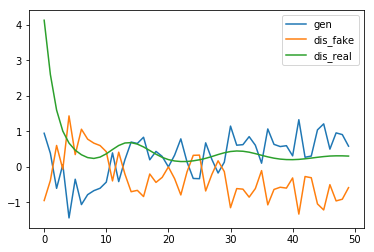

Generation 28  fitness : 2.1789999273424514
#################################
population fitness : [ 463.  607. 5000. 5000. 5000. 5000. 5000.  435.  339.]
min fit : 5000.0
population fitness : [0.2051959  0.26901563 2.21596064 2.21596064 2.21596064 2.21596064
 2.21596064 0.19278651 0.15024002]
4.999999999999804
tensor([-0.2311, -0.1799,  1.6785,  1.4380,  2.0431,  1.8276,  1.8035, -0.5248],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


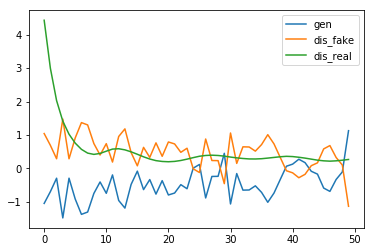

Generation 29  fitness : 2.215960635447279
#################################
population fitness : [5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]
min fit : 5000.0
population fitness : [4999849.75997692 4999849.75997692 4999849.75997692 4999849.75997692
 4999849.75997692 4999849.75997692 4999849.75997692 4999849.75997692
 4999849.75997692]
-inf


/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


tensor([23.6502, 24.5292, 25.9150, 24.0650, 22.1636, 25.5301, 27.6978, 25.7569],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


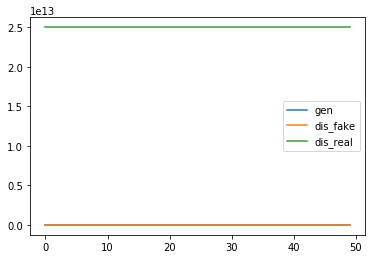

/home/liam/Documents/GitHub/Evolution/helper.py:48: RuntimeWarning: invalid value encountered in true_divide
  pick_probabilities = normed/(np.sum(normed))
/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


Generation 30  fitness : 4999849.759976919
#################################
population fitness : [5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]
min fit : 5000.0
population fitness : [0. 0. 0. 0. 0. 0. 0. 0. 0.]
-inf
tensor([0.7570, 0.7494, 0.8016, 0.7953, 0.7985, 0.7925, 0.7649, 0.7826],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


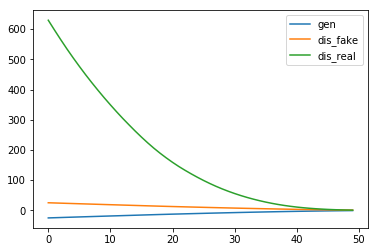

Generation 31  fitness : 0.0
#################################
population fitness : [ 214. 5000. 5000.  707. 5000. 5000.   96.  224.  224.]
min fit : 5000.0
population fitness : [0.0912857  2.13284349 2.13284349 0.30158407 2.13284349 2.13284349
 0.04095059 0.09555139 0.09555139]
4.999999999999818
tensor([-0.2512,  1.8455,  1.8377,  0.0081,  1.4524,  1.6613, -0.4150, -0.5882],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


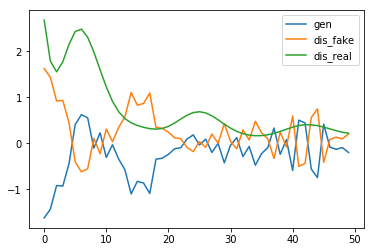

Generation 32  fitness : 2.132843488347539
#################################
population fitness : [5000.  377. 5000. 5000. 5000.  102.  765.   10.    9.]
min fit : 5000.0
population fitness : [2.11071432 0.15913188 2.11071432 2.11071432 2.11071432 0.04304164
 0.32292465 0.00420418 0.00378203]
4.9999999999998215
tensor([ 1.5645, -0.1024,  1.6511,  1.7695,  1.5001, -0.3683, -0.0994, -0.7433],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


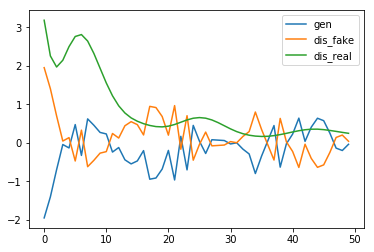

Generation 33  fitness : 2.110714320154191
#################################
population fitness : [5000.  327. 5000.  145. 5000.  105. 5000. 5000. 5000.]
min fit : 5000.0
population fitness : [2.20551535 0.14423914 2.20551535 0.06395833 2.20551535 0.04631419
 2.20551535 2.20551535 2.20551535]
4.999999999999805
tensor([ 1.8865, -0.3055,  1.7788, -0.4240,  1.9166, -0.4323,  1.6669,  1.3355],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


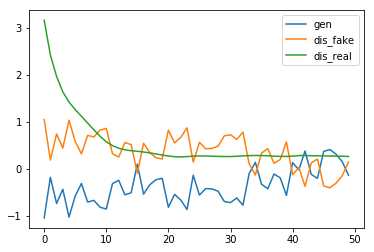

Generation 34  fitness : 2.205515349331482
#################################
population fitness : [ 523. 5000. 5000.  444.  374.  113. 5000. 1148. 1017.]
min fit : 5000.0
population fitness : [0.24975997 2.387952   2.387952   0.21202998 0.17859834 0.0539461
 2.387952   0.54825674 0.48569182]
4.999999999999772
tensor([-0.1311,  1.8921,  2.1485, -0.2008, -0.3357, -0.4929,  1.8502, -0.0637],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


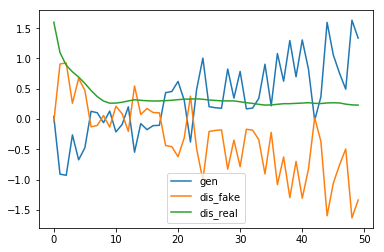

Generation 35  fitness : 2.387952000944884
#################################
population fitness : [5000.   12. 5000.   88. 5000.    8.  850.  151.  161.]
min fit : 5000.0
population fitness : [2.20284434 0.00526312 2.20284434 0.03874671 2.20284434 0.00350082
 0.37446381 0.06650285 0.07090859]
4.9999999999998055
tensor([ 1.8141, -0.4619,  1.7608, -0.4206,  1.8498, -0.4722,  0.0416, -0.6418],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


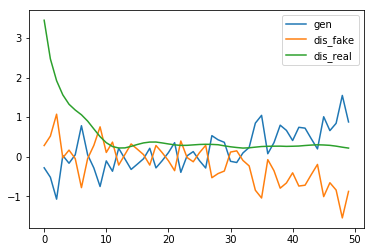

Generation 36  fitness : 2.2028443394615533
#################################
population fitness : [5000.  557. 5000.    8. 3509. 5000.  158.   21.   12.]
min fit : 5000.0
population fitness : [2.20180998 0.24528026 2.20180998 0.00352136 1.54522978 2.20180998
 0.0695757  0.00924607 0.00528281]
4.9999999999998055


In [ ]:
#randomly inititialise starting population
population_size = 2
max_population = 8    

batch_size = population_size
out_size = population_size
ranking = np.zeros([population_size])
parent_fitness = np.zeros([population_size])
population = []

for p in range(population_size):
    population.append(Creature().to(device))
old_population = population 

gen = Generator().to(device)
old_gen = gen
dis = Discriminator().to(device)

lr = 0.0001

print("starting training")
print(len(get_params(Creature())))
n_generations = 300


fit_bank = np.array([])

for i in range(n_generations):

    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr,betas=(0.9,0.999))
    p_fitness, behavior_samples = measure_population_fitness(population,env,device,discrete_actions,
                                                             max_steps = 5000)
    
    
    
    
    #print(normed)
    if i == 0:
        old_fitness = p_fitness
    print("population fitness : {}".format(p_fitness))
    print("min fit : {}".format(np.mean(np.sort(p_fitness)[p_fitness.size-p_fitness.size//4:])))
    
    p_fitness = (p_fitness - np.min(np.concatenate([p_fitness,old_fitness])))/np.sqrt(np.var(p_fitness)+0.000001)
    print("population fitness : {}".format(p_fitness))
    #p_fitness =(p_fitness - np.min(p_fitness))/(np.max(p_fitness)-np.min(p_fitness))
    
    
    cat = np.concatenate([p_fitness,old_fitness])
    #min_fit = np.mean(np.sort(cat)[cat.size-cat.size//4:])
    min_fit = np.mean(np.sort(p_fitness)[p_fitness.size-p_fitness.size//4:])
    
    
    
    fit_bank = np.array(old_population)[np.where(old_fitness>min_fit)]
    fit_bank_fitness = np.array(old_fitness)[np.where(old_fitness>min_fit)]
    
    new_population = population
    new_population = np.concatenate((population,fit_bank))
    new_fitness = p_fitness
    new_fitness = np.concatenate((p_fitness,fit_bank_fitness))
    #new_batch_size = batch_size+fit_bank.size
    #new_batch_size = new_population.size
    new_batch_size = batch_size
    
    n_epochs = 50
    gen_loss, dis_loss,rec_loss = train_gan(population,p_fitness,
              batch_size =new_batch_size,n_epochs = n_epochs)
    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis_fake')
    plt.plot(rec_loss,label='dis_real')
    #plt.ylim(-30, 30)
    plt.legend()
    plt.show()
    
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,
                                  render = True,max_steps = 500)
    
    child_mutation_rate = 0.1
    mutation_scale = 0.07
    mutation_rate = np.ones(p_fitness.shape) * 0.1
    
    if np.mean(p_fitness) < 13:
        child_mutation_rate = 1
        mutation_rate = np.ones(p_fitness.shape)
        mutation_scale = 0.9
        child_mutation_rate = 1
        
    if out_size < max_population:
        out_size+=2
        batch_size = out_size
    
    old_population = population
    old_fitness = p_fitness
    population, parent_fitness = evolve(population,out_size,gen,old_gen,p_fitness,child_mutation_rate,
                                        mutation_rate,mutation_scale)
    old_gen = gen
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness)))
    print("#################################")
